# Exam paper: Optimal Energy mix in Greenland
### _Group 1: Marie Louise, Sofie & Caroline_

We import the basic packages:

In [45]:
#%run ../stdPackages.ipynb
from pyDbs import *
from IPython.display import Image
figs_path = os.path.join(d['curr'],'Figs')


We create a path to data

In [46]:
path_to_data = os.path.join(d['curr'], 'Exercises', 'E44','Data','E44_Data-ny.xlsx')
print(path_to_data)

c:\Users\CAAL\Dropbox\Polit\Nuuk-Energy-mix\Exercises\E44\Data\E44_Data-ny.xlsx


In [47]:
kwargs = {'variables': ['Fundamentals', 'Load', 'Generators_Other'],
        'maps': ['Generators_Categories','hMaps'],
        'variable2D': ['HourlyVariation','Generators_FuelMix'],
        'scalars': ['Scalars']}

db = read.dbFromWB(path_to_data, kwargs)
readSets(db)

Finally, make sure your code is correct by solving for the baseline scenario, where this is no storage:

In [48]:
from Exam import *
m = mSimple(db)
m()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


Save solution for later:

In [49]:
base_db = m.db.copy()

In the following, we aggregate the fuel types to the following types:

In [50]:
agg_BFt = {
    'Fueloil':'Oil','Gasoil':'Oil', 
    'Straw':'Biomass','WoodPellets':'Biomass','WoodChips':'Biomass','WoodWaste':'Biomass',
    'Biogas':'Other Bio','BioOil':'Other Bio',
    'Coal':'Coal',
    'NatGas':'Natural gas',
    'Waste':'Waste'
}

# The optimal combination of wind and hydro

First, we define the vectors. 

Since Buksefjordsværket in Nuuk already has a capacity of 45 mW, and the planned expantion of the hydro power plant is 55 mW (in all 100 mW), the vector of hydro goes from 45 to 100. 

Thus, the vector of wind goes from 0 to 55 mW. 

Each vector contains five points, and so we have 25 combinations of hydro and wind.

In [51]:
# Defining vectors for wind and hydro
vec_hydro = np.linspace(45, 100, 5)
vec_wind = np.linspace(0, 55, 5)

# printing vectors
print("Vector for hydro:", vec_hydro)
print("Vector for wind:", vec_wind)


Vector for hydro: [ 45.    58.75  72.5   86.25 100.  ]
Vector for wind: [ 0.   13.75 27.5  41.25 55.  ]


## __Storage__

Secondly, we create two dataframes, 'grid_ECap' and 'grid_SCap', representing electricity capacity and storage capacity, respectively. 

These dataframes are organized using multi-indexing and are based on specified loops ('loop' and 'loop_2'). 

Maximum capacity and the initial values for the capacity are defined by 'maxcap', 'E2P', 'v0_ECap', and 'vT_ECap' for electricity, and similarly for storage with 'v0_SCap' and 'vT_SCap'.

In [52]:
# The "energy storage to power"-ratio/storage duration 
E2P = 5000

# defining of minimum electricity
min_electricity = vec_hydro[0]+vec_wind[0]
# definition of max electricity
max_electricity = vec_hydro[4]+vec_wind[0]


# defining of minimum storage
min_storage = vec_hydro[0]
# definition of max storage
max_storage = vec_hydro[4]

# Defining two loops
loop_hydro = pd.Index(range(5), name = 'loop_hydro')
loop_wind = pd.Index(range(5), name = 'loop_wind')

# defining lower and upper bound for electricity production
v0_ECap = pd.Series(min_electricity, index = getTechs(['Storage', 'Standard'], m.db))
vT_ECap = pd.Series(max_electricity, index = getTechs(['Storage', 'Standard'], m.db))

# defining lower and upper bound for electricity storage by multiplying E2P with the energy production
v0_SCap = pd.Series(min_storage, index = getTechs(['Storage'], m.db))*E2P
vT_SCap = pd.Series(max_storage, index = v0_SCap.index)*E2P

# First grid with electricity bounds (the grid consist of a multi index --> two dimentional)
grid_ECap = adjMultiIndex.addGrid(v0_ECap, vT_ECap, loop_hydro, 'GeneratingCapacity').astype(int)

# Second grid with a storage cap running through loop 2
grid_SCap = adjMultiIndex.addGrid(v0_SCap, vT_SCap, loop_wind,'sCap').astype(int)

In [53]:
vT_SCap

id
idES    500000.0
dtype: float64

Third, we define a grid with two dimentions, so that the grid contains both electricity generation from hydro and wind

In [54]:
def grid(vec_hydro, vec_wind, index, gridtype='linear', phi=1): 

    if gridtype == 'linear': # If v0, vT are one dimentional numpy arrays, returns two dimentional array. 
        return np.linspace(vec_hydro, vec_wind, len(index)) 
      
    elif gridtype=='polynomial': # If scalars, returns one dimentional arrays.
        return np.array([vec_hydro+(vec_wind-vec_hydro)*((i-1)/(len(index)-1))**phi for i in range(1,len(index)+1)])

In [55]:
def addGrid(vec_hydro, vec_wind, index, name, gridtype = 'polynomial', phi = 1, sort_levels=None, sort_index = False): # NB: Make sure that v0 and vT are sorted similarly (if they are defined over indices)
    
    if sort_index:
        vec_hydro = vec_hydro.sort_index()
        vec_wind = vec_wind.sort_index()

    if isinstance(vec_hydro, pd.Series):
        return pd.DataFrame(grid(vec_hydro, vec_wind, index, gridtype=gridtype, phi=phi).T, index = vec_hydro.index, columns = index).stack().rename(name).reorder_levels(index.names+vec_wind.index.names if sort_levels is None else sort_levels)
    
    else:
        return pd.Series(grid(vec_hydro, vec_wind, index, gridtype=gridtype, phi=phi), index=index, name=name)

Then, we converge the vectors into flat indexs 

In [56]:
import lpCompiler

In [57]:
df_E = lpCompiler.sortAll(addGrid(grid_ECap, grid_ECap, loop_wind, 'GeneratingCap_E').unstack('id'))
df_S = lpCompiler.sortAll(addGrid(grid_SCap, grid_SCap, loop_hydro, 'sCap').unstack('id'))

# redefining the name of the loops
df_E.index = df_E.index.to_flat_index().rename('loop')
df_S.index = df_S.index.to_flat_index().rename('loop')

# 
grid_ECap_1d = df_E.stack().rename('GenerationCapacity')
grid_SCap_1d = df_S.stack().rename('GenerationCapacity')

# Defining the loop as an index
loop = df_E.index

Then, we extract the following variables:

Vi har desuden fjernet alle emmissionsvariable, da vi kun har VE-anlæg

In [58]:
extract = ['marginalSystemCosts','Generation','charge','discharge','capturePrice','marketValueFactor','capacityFactor','marginalEconomicValue','consumerSurplus','producerSurplus','Welfare']

In [59]:
print('mWh capacity storage is given by:')
grid_SCap_1d

mWh capacity storage is given by:


loop    id  
(0, 0)  idES    225000.0
(0, 1)  idES    293750.0
(0, 2)  idES    362500.0
(0, 3)  idES    431250.0
(0, 4)  idES    500000.0
(1, 0)  idES    225000.0
(1, 1)  idES    293750.0
(1, 2)  idES    362500.0
(1, 3)  idES    431250.0
(1, 4)  idES    500000.0
(2, 0)  idES    225000.0
(2, 1)  idES    293750.0
(2, 2)  idES    362500.0
(2, 3)  idES    431250.0
(2, 4)  idES    500000.0
(3, 0)  idES    225000.0
(3, 1)  idES    293750.0
(3, 2)  idES    362500.0
(3, 3)  idES    431250.0
(3, 4)  idES    500000.0
(4, 0)  idES    225000.0
(4, 1)  idES    293750.0
(4, 2)  idES    362500.0
(4, 3)  idES    431250.0
(4, 4)  idES    500000.0
Name: GenerationCapacity, dtype: float64

Her tilføjes en ekstra variable, da storage muligheden også udvider sig grundet udvidelse af vandkraftværk. Derfor tager det også længere tid at tømme reservioret. Man kan se, at de følges ad --> så reservioret ikke tømmes hurtigere pga. udvidelse heraf men tværdigmod

In [60]:
grid_SCap_1d2 = (grid_SCap_1d*5000).rename('SCap')

In [61]:
loop

Index([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3),
       (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2),
       (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)],
      dtype='object', name='loop')

Finally, we run the solutions based on the 25 combinations

In [62]:
solution = m.loopSolveExtract(loop, [grid_ECap_1d, grid_SCap_1d], extract)

In [63]:
solution['Welfare'] 

loop
(0, 0)    7.199521e+06
(0, 1)    7.199521e+06
(0, 2)    7.199521e+06
(0, 3)    7.199521e+06
(0, 4)    7.199521e+06
(1, 0)    7.199521e+06
(1, 1)    7.199521e+06
(1, 2)    7.199521e+06
(1, 3)    7.199521e+06
(1, 4)    7.199521e+06
(2, 0)    7.199521e+06
(2, 1)    7.199521e+06
(2, 2)    7.199521e+06
(2, 3)    7.199521e+06
(2, 4)    7.199521e+06
(3, 0)    7.199521e+06
(3, 1)    7.199521e+06
(3, 2)    7.199521e+06
(3, 3)    7.199521e+06
(3, 4)    7.199521e+06
(4, 0)    7.199521e+06
(4, 1)    7.199521e+06
(4, 2)    7.199521e+06
(4, 3)    7.199521e+06
(4, 4)    7.199521e+06
dtype: float64

In [64]:
solution['marginalSystemCosts']

h     loop  
1     (0, 0)    2.0
      (0, 1)    2.0
      (0, 2)    2.0
      (0, 3)    2.0
      (0, 4)    2.0
               ... 
8760  (4, 0)    2.0
      (4, 1)    2.0
      (4, 2)    2.0
      (4, 3)    2.0
      (4, 4)    2.0
Length: 219000, dtype: float64

<Axes: xlabel='h'>

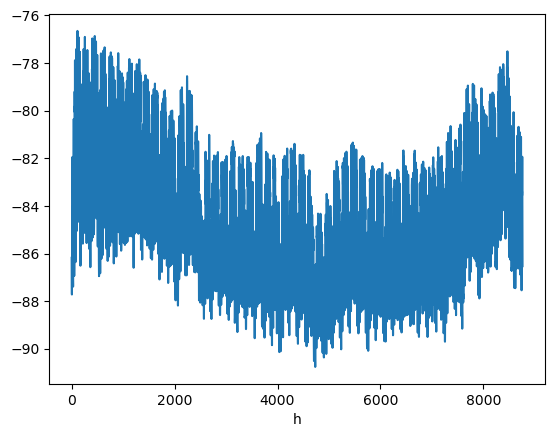

In [65]:
(m.hourlyLoad - m.hourlyGeneratingCap.xs('idES')).plot()

In [66]:
# bør være 0, da vi arbejder med vandreservior og ikke tilbagefører vandet
solution['charge'].loc[:, 'idES', (2,2)]

h
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
       ... 
8756    0.0
8757    0.0
8758    0.0
8759    0.0
8760    0.0
Length: 8760, dtype: float64

In [67]:
# bør altid være positiv, da vi har en minimum værdi af 45 MW
solution['discharge'].loc[:, 'idES', (2,2)]

h
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
          ...   
8756    0.000000
8757    0.000000
8758    0.000000
8759    0.008391
8760    0.000000
Length: 8760, dtype: float64

# Appendix

The table below translates the names used in the data to the symbols used in the model. 

| Name in excel file | Model symbol |
|:--------|:--------:|
| id | $i$ | 
| BFt | $j$ |
| h | $h$ |
|  FuelMix   |  $\mu_{i,j}$   |
|  GeneratingCapacity   | $q_i$   |
|  OtherMC   | $c_i^{oth}$   |
| FuelPrice | $p_j^f$ |
| EmissionIntensity | $\phi_j$ |
| MWP | $\mu$ |
| LoadVariation $\times$ Load | $D_h$ |
| CapVariation | $\gamma_{i,h} $ |
| sCap | $\overline{S}_i$ |
| effS | $\sqrt{\eta_i}$ |

Note that $c$ is also an index for the consumer type in the data file. In the model in [**Part 1**](#Part-1:-Analytical-Exercises), however, there is only a single representative consumer. But since $c=c1$ always, this is equivalent.

The following section imports the data: